In [1]:
import gensim
import gzip
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
#knock80.py
from collections import Counter
import torch
from torch import nn

def create_wordids(file_name):
    counter = Counter()
    with open(file_name, encoding="utf-8") as f:
        for line in f:
            line = line.strip().split('\t')[1]
            for word in line.split():
                counter[word] += 1
    wordids = {}
    ids=0
    for word, count in counter.most_common():
        if count < 2: continue
        ids += 1
        wordids[word] = ids
    return wordids

def sentence2ids(wordids, line):
    line = line.split(" ")
    for i in range(len(line)):
        if line[i] in wordids:
            line[i] = wordids[line[i]]
        else:
            line[i] = 0
    return line
            
wordids = create_wordids(r'C:\Git\train.txt')
print(sentence2ids(wordids, 'Independence Day Pump Prices May Hit 6-Year High on Iraq'))

[6690, 124, 6691, 447, 51, 2082, 4978, 158, 4, 168]


In [3]:
#knock81.py
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, padding_idx):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def init_hidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size).to(device)
        
    def forward(self, x):
        self.batch_size = x.size()[0]
        embed = self.embedding(x)
        out, hidden = self.rnn(embed, self.init_hidden())
        out = F.relu(self.fc(out[:,-1,:]))
        return out

In [4]:
#knock82.py
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
cat = str.maketrans({'b':'0', 't':'1', 'e':'2', 'm':'3'})

def create_dataset(file_name):
    with open(file_name, encoding="utf-8") as f:
        x_vec=[]
        y_vec=[]
        average = 0
        for line in f:
            y, sent = line.strip().split('\t')
            x_vec.append(sentence2ids(wordids, sent))
            y_vec.append(int(y.translate(cat)))
        x_vec = ids2tensor(x_vec, int(np.mean([len(a) for a in x_vec])))
        y_vec = torch.tensor(y_vec, dtype = torch.int64)
        return x_vec, y_vec

def ids2tensor(vec, max_length):
    x_vec = []
    for ids in vec:
        if len(ids) > max_length:
            ids = ids[:max_length]
        else:
            ids += [len(wordids)] * (max_length - len(ids))
        x_vec.append(ids)
    return torch.tensor(x_vec, dtype=torch.int64)

def create_data(x, y):
    data = []
    for i in range(len(y)):
        data.append([x[i], y[i]])
    return data

def calc_accuracy(pred, answer):
    correct = 0
    for i in range(len(answer)):
        if pred[i] == answer[i]: correct+=1
    return correct/len(answer)

model = RNN(len(wordids)+1, 300, 50, 4, len(wordids))
x_train, y_train = create_dataset(r'C:\Git\train.txt')
x_test, y_test = create_dataset(r'C:\Git\test.txt')
dataset = create_data(x_train, y_train)
train_loader = DataLoader(dataset, shuffle = True)
optim = torch.optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
for epoch in tqdm(range(10)):
    for inputs, target in train_loader:
        optim.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, target)
        loss.backward()
        optim.step()
    with torch.no_grad():
        pred = model(x_train)
        train_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_train))
        train_loss.append(loss_func(pred, y_train))
        pred = model(x_test)
        test_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_test))
        test_loss.append(loss_func(pred, y_test))

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.subplot(1,2,2)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

NameError: name 'device' is not defined

  0%|          | 0/10 [00:00<?, ?it/s]

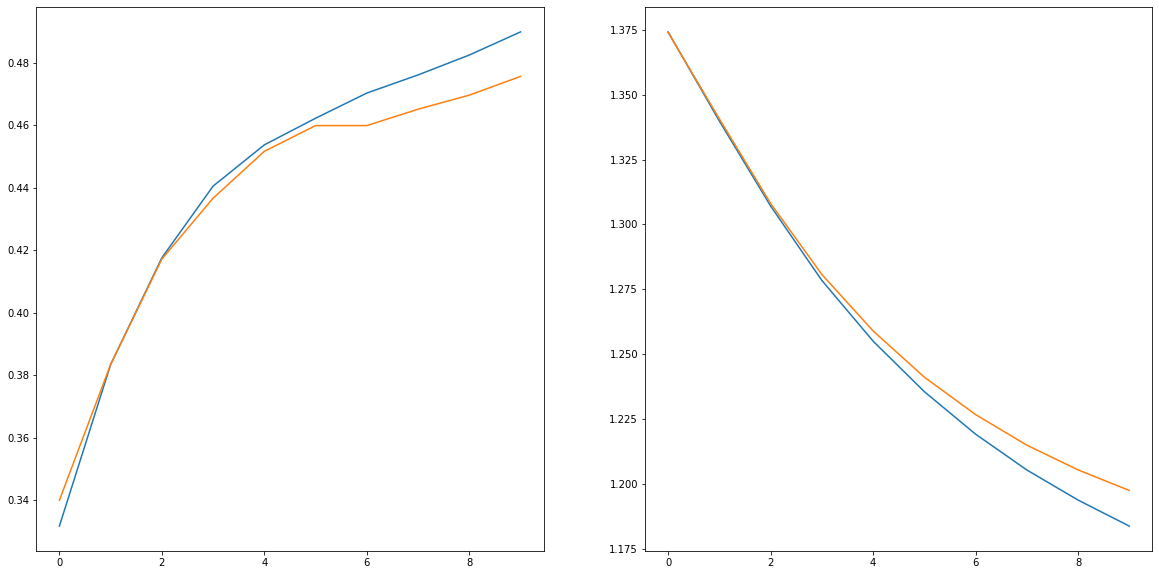

In [49]:
#knock83.py
device = torch.device('cuda')
model = RNN(len(wordids)+1, 300, 50, 4, len(wordids))
x_train, y_train = create_dataset(r'C:\Git\train.txt')
x_test, y_test = create_dataset(r'C:\Git\test.txt')
dataset = create_data(x_train, y_train)
train_loader = DataLoader(dataset, batch_size = 16, shuffle = True)
optim = torch.optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
for epoch in tqdm(range(10)):
    for inputs, target in train_loader:
        optim.zero_grad()
        model.to(device)
        inputs = inputs.to(device)
        target = target.to(device)
        outputs = model(inputs)
        loss = loss_func(outputs, target)
        loss.backward()
        optim.step()
    with torch.no_grad():
        x_train = x_train.to(device)
        x_test = x_test.to(device)
        pred = model(x_train)
        train_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_train))
        train_loss.append(loss_func(pred, y_train.to(device)).detach().cpu().numpy())
        pred = model(x_test)
        test_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_test))
        test_loss.append(loss_func(pred, y_test.to(device)).detach().cpu().numpy())

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.subplot(1,2,2)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.show()

In [6]:
#knock84.py
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, padding_idx, vocabweights):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(vocabweights, padding_idx=padding_idx)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def init_hidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size).to(device)
        
    def forward(self, x):
        self.batch_size = x.size()[0]
        embed = self.embedding(x)
        out, hidden = self.rnn(embed, self.init_hidden())
        out = F.relu(self.fc(out[:,-1,:]))
        return out

wordvec = gensim.models.KeyedVectors.load_word2vec_format(r'C:\Git\GoogleNews-vectors-negative300.bin.gz', binary=True)
vocabweights = np.zeros((len(wordids)+1, 300))
for i, word in enumerate(wordids.keys()):
    if word in wordvec:
        vocabweights[i] = wordvec[word]
    else:
        vocabweights[i] = 0.2*np.random.rand(300)-0.1
vocabweights = torch.from_numpy(vocabweights.astype((np.float32)))

device = torch.device('cuda')
model = RNN(len(wordids)+1, 300, 50, 4, len(wordids), vocabweights)
x_train, y_train = create_dataset(r'C:\Git\train.txt')
x_test, y_test = create_dataset(r'C:\Git\test.txt')
dataset = create_data(x_train, y_train)
train_loader = DataLoader(dataset, batch_size = 16, shuffle = True)
optim = torch.optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
for epoch in tqdm(range(10)):
    for inputs, target in train_loader:
        optim.zero_grad()
        model.to(device)
        inputs = inputs.to(device)
        target = target.to(device)
        outputs = model(inputs)
        loss = loss_func(outputs, target)
        loss.backward()
        optim.step()
    with torch.no_grad():
        x_train = x_train.to(device)
        x_test = x_test.to(device)
        pred = model(x_train)
        train_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_train))
        train_loss.append(loss_func(pred, y_train.to(device)).detach().cpu().numpy())
        pred = model(x_test)
        test_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_test))
        test_loss.append(loss_func(pred, y_test.to(device)).detach().cpu().numpy())

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.subplot(1,2,2)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
#knock85.py
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, padding_idx, vocabweights):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(vocabweights, padding_idx=padding_idx)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first = True, bidirectional = True)
        self.fc = nn.Linear(hidden_size*2, output_size)
        
    def init_hidden(self):
        return torch.zeros(2, self.batch_size, self.hidden_size).to(device)
        
    def forward(self, x):
        self.batch_size = x.size()[0]
        embed = self.embedding(x)
        out, hidden = self.rnn(embed, self.init_hidden())
        out = F.relu(self.fc(out[:,-1,:]))
        return out

device = torch.device('cuda')
model = RNN(len(wordids)+1, 300, 50, 4, len(wordids), vocabweights)
x_train, y_train = create_dataset(r'C:\Git\train.txt')
x_test, y_test = create_dataset(r'C:\Git\test.txt')
dataset = create_data(x_train, y_train)
train_loader = DataLoader(dataset, batch_size = 1, shuffle = True)
optim = torch.optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
for epoch in tqdm(range(10)):
    for inputs, target in train_loader:
        optim.zero_grad()
        model.to(device)
        inputs = inputs.to(device)
        target = target.to(device)
        outputs = model(inputs)
        loss = loss_func(outputs, target)
        loss.backward()
        optim.step()
    with torch.no_grad():
        x_train = x_train.to(device)
        x_test = x_test.to(device)
        pred = model(x_train)
        train_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_train))
        train_loss.append(loss_func(pred, y_train.to(device)).detach().cpu().numpy())
        pred = model(x_test)
        test_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_test))
        test_loss.append(loss_func(pred, y_test.to(device)).detach().cpu().numpy())

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.subplot(1,2,2)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [42]:
#knock86.py
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, padding_idx, vocabweights):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=padding_idx)
        self.conv = nn.Conv1d(embedding_size, hidden_size, 3, padding=1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)
        self.pool = nn.MaxPool1d(10)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.shape[0], x.shape[2], x.shape[1])
        x = F.relu(self.conv(x))
        x = x.view(x.shape[0], x.shape[1], x.shape[2])
        x = self.pool(x)
        x = x.view(x.shape[0], x.shape[1])
        x = self.fc(self.dropout(x))
        return x

model = CNN(len(wordids)+1, 300, 50, 4, len(wordids), vocabweights)
model = model.to(device)
for inputs, target in train_loader:
    inputs = inputs.to(device)
    target = target.to(device)
    print(model(inputs))

tensor([[-0.2941, -0.2258, -0.3291, -0.1190]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3940,  0.2533, -0.0305,  0.2272]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7681,  0.4749, -0.2617,  0.5265]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.9449,  0.1910,  0.4982, -0.2843]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3671,  0.0055,  0.0607, -0.0729]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.2522,  0.5100, -0.0614, -0.5638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4788,  0.3247, -0.6448, -0.1939]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0274, -0.0678, -0.4113, -0.3381]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3348,  0.4691, -0.4825,  0.0300]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5838, 0.4557, 0.4521, 0.1911]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4825, 0.4338, 0.4748, 0.2840]], d

tensor([[ 0.1709, -0.2807,  0.2637,  0.5009]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1445, -0.0113, -0.2458, -0.0854]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4282, 0.0524, 0.0257, 0.0360]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2445, -0.0755, -0.3604, -0.0668]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1781, -0.5539,  0.7522,  0.2855]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7567, 0.5404, 0.0510, 0.8130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3777, -0.1210,  0.0724,  0.3348]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4477,  0.7466, -0.2971, -0.3888]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6323,  0.3423, -0.6635, -0.0108]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5250,  0.0685,  0.6705, -0.0331]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0271,  0.1499,  0.4934,  0.0991]], d

tensor([[ 0.7789, -0.0597,  0.2517,  0.3889]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5105, -0.0727,  0.4017, -0.2032]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0816,  0.5774,  0.4400, -0.2607]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3788, -0.1659,  0.0458,  0.0239]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3433,  0.2887, -0.1256,  0.1622]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4701, 0.5574, 0.1578, 0.1892]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3510,  0.6485, -0.3356, -0.2395]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0642,  0.0705,  0.6062, -0.1326]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3722, 0.1990, 0.1189, 0.6867]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.8128, -0.1150,  0.7048,  0.3951]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2686,  0.4083,  0.1271, -0.0467]], d

tensor([[ 0.4621,  0.0262, -0.3284,  0.3606]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7758,  0.3977,  0.5722, -0.1309]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7391, 0.2326, 0.6005, 0.2786]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2434, 0.4641, 0.1410, 0.1311]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3984,  0.5930, -0.0527, -0.0174]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1725, 0.7907, 0.4331, 0.0049]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1187,  0.2194, -0.5208, -0.3310]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0134, -0.0226, -0.2277, -0.1857]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2534,  0.6713, -0.2117,  0.1438]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4772, -0.1970,  0.2911, -0.2893]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.4235,  0.5173, -0.4513, -0.2024]], devic

tensor([[ 0.3495,  0.7789, -0.1552,  0.5925]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5352, 0.1313, 0.3561, 0.2634]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0707,  0.0817, -0.1095,  0.0960]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1737, 0.3286, 0.0371, 0.2908]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5977,  0.1996,  0.3651, -0.1653]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2406, -0.0454,  0.4142, -0.2106]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2018,  0.0406, -0.4500,  0.4577]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1234,  0.5627, -0.2606, -0.0257]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7931, 0.3411, 0.0748, 0.6137]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3536, -0.3974,  0.2334, -0.0932]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5893, 0.4543, 0.0405, 0.2308]], device='c

tensor([[0.3148, 0.2153, 0.3864, 0.2587]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6538, 0.4811, 0.1241, 0.0150]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7619,  0.3958,  0.4698, -0.1936]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4283,  0.6672, -0.0692,  0.0346]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1251,  0.3489, -0.3340, -0.4164]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8831, 0.5143, 0.2560, 0.1857]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0620, -0.1092, -0.3621, -0.2349]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2427,  0.4652, -0.0453, -0.1724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3591, 0.4848, 0.3023, 0.5207]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.3195,  0.4544,  0.3956, -0.0085]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3299, -0.2645, -0.3559,  0.2597]], device='c

tensor([[ 0.3638,  0.1803, -0.1134, -0.0916]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4303,  0.2594,  0.2075, -0.0479]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4610, 0.6346, 0.2064, 0.4798]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3851,  0.1116,  0.0322, -0.1298]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.4490,  0.2357, -0.0226, -0.3309]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0876, -0.1506,  0.4042, -0.0838]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5905,  0.2109, -0.3401,  0.6881]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2677, -0.1573,  0.7570, -0.1638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3785, 0.2557, 0.0508, 0.3370]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4515, -0.3765, -0.1041,  0.1926]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1494, -0.1566,  0.2697, -0.0640]], d

tensor([[ 0.3789,  0.9021, -0.8279,  0.3996]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1375,  0.5118,  0.0520, -0.0136]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5422,  0.0238, -0.3428,  0.2058]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6417, -0.1370,  0.8223, -0.1102]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5745,  0.1133,  0.2709, -0.5236]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5782,  0.3215,  0.1288, -0.1341]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1029, 0.1972, 0.2013, 0.0172]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2478,  0.6023, -0.0590,  0.0654]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1972,  0.4023, -0.2126, -0.1225]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3190,  0.2677, -0.1186, -0.0624]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3279, -0.1976, -0.0764, -0.2968]

tensor([[-0.3051,  0.1548, -0.0444, -0.5277]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2814,  0.0519, -0.2519, -0.1226]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6566, 0.2844, 0.3165, 0.1800]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3741,  0.2293, -0.1985,  0.0186]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0579,  0.4267,  0.4205, -0.5522]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0097, -0.0429,  0.1160,  0.1926]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2768,  0.4246, -0.3406, -0.3955]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1404, -0.1591,  0.4306,  0.2339]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2901, 0.5038, 0.1204, 0.0668]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3845, 0.1028, 0.7536, 0.0205]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1676,  0.5429, -0.1767, -0.1138]], devic

tensor([[0.0949, 0.1178, 0.3444, 0.1217]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.8761,  0.6503, -0.4132, -0.1601]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2777,  0.6464, -0.2367,  0.3582]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5822, 0.0301, 0.1214, 0.2229]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3584,  0.2235,  0.1895, -0.1798]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3444, 0.1099, 0.2215, 0.5089]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2414,  0.1463, -0.2416,  0.1958]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5403, 0.1382, 0.0980, 0.0686]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5214,  0.4790,  0.2992, -0.1102]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3748,  0.2634, -0.2024,  0.5118]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0501, -0.0638, -0.6231, -0.4743]], device='c

tensor([[-0.0362, -0.2990,  0.2610, -0.1232]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1299, 0.4934, 0.0774, 0.0188]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4221,  0.0164,  0.3331, -0.2180]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4495, -0.0209,  0.4117,  0.3464]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0648,  0.1450,  0.4541, -0.2656]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0689, -0.2101, -0.1657, -0.1127]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3353,  0.2946, -0.2562,  0.3491]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1014,  0.1408,  0.0940, -0.0673]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4605,  0.3565, -0.0264, -0.0850]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1992,  0.1920,  0.6151, -0.4418]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6766,  0.0558, -0.1347, -0.5215]

tensor([[0.1276, 0.1283, 0.2133, 0.1499]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4662, -0.2842, -0.0733,  0.2904]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3291,  0.2890, -0.0147, -0.1943]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4767,  0.6966, -0.4717,  0.4923]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2339, 0.5363, 0.1236, 0.2621]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5248, 0.2644, 0.3321, 0.2611]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0172,  0.1040,  0.0011, -0.4044]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7251, -0.3434, -0.2667, -0.4659]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4465, 0.2790, 0.3330, 0.2301]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0996, 0.2629, 0.2444, 0.0771]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3204, 0.5132, 0.0051, 0.3325]], device='cuda:0',


tensor([[ 0.4585, -0.1278,  0.2483, -0.3614]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4761, -0.0424, -0.1790, -0.1101]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2613,  0.6576,  0.2679, -0.2029]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2453,  0.2501, -0.4877,  0.2297]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5134, -0.2490,  0.1772,  0.2360]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9644, 0.3946, 0.1021, 0.2780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3218, 0.1540, 0.7356, 0.2405]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2422,  0.1270,  0.1229, -0.2342]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3755,  0.3136,  0.5439, -0.0822]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0478,  0.5254, -0.2986, -0.2919]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4367, 0.0184, 0.0808, 0.0015]], devic

tensor([[0.2159, 0.1360, 0.0465, 0.0195]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0959,  0.2866,  0.3381,  0.1403]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5375,  0.3703,  0.3738, -0.0679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4030,  0.0747, -0.0988, -0.3979]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4732,  0.3286, -0.0303,  0.2855]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2307, -0.0530, -0.0393,  0.4646]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0857,  0.4676, -0.3271,  0.4307]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0445, -0.3242,  0.1361, -0.2871]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3061, -0.0600,  0.2749,  0.4819]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2218, -0.0898,  0.8088, -0.3272]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2317,  0.2017,  0.0999, -0.1994]

tensor([[0.7955, 0.4578, 0.1650, 0.1153]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4350,  0.2958, -0.2453,  0.1323]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3941, -0.0231, -0.8066, -0.2062]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7914,  0.4972, -0.2063,  0.3423]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4232, 0.1589, 0.5146, 0.2707]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5740,  0.4402, -0.2142, -0.1001]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7395,  0.6513, -0.2928,  0.7723]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2411,  0.3560, -0.2006,  0.3170]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0299, -0.3452,  0.3194, -0.3552]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6500, -0.2854,  0.4552,  0.2718]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.2552, -0.0120,  0.1922, -0.4181]], d

tensor([[ 0.2561,  0.4452, -0.1015,  0.1641]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2273, -0.1191,  0.2232, -0.0471]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.8138,  0.2952, -0.0141,  0.0734]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0149,  0.2815, -0.3717, -0.6489]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3674,  0.4217, -0.1145,  0.0165]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2984, 0.2439, 0.0023, 0.0796]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3000,  0.7725,  0.1598, -0.0960]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2824, -0.1409,  0.3583, -0.2558]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0284,  0.0151, -0.1335, -0.2354]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5984, 0.1698, 0.1324, 0.4516]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5353, 0.4034, 0.1510, 0.0482]], devic

tensor([[ 0.2428, -0.0062, -0.0303,  0.1345]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2777, -0.0708,  0.1280,  0.1493]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2645,  0.0490, -0.0323, -0.1683]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4190,  0.3464, -0.3231,  0.1681]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.9444, -0.0921,  0.3857,  0.4425]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2977, 0.1615, 0.2435, 0.0885]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2910,  0.1723,  0.5104, -0.4198]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2687,  0.4535,  0.1209, -0.0171]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0441, -0.4374,  0.1911,  0.1825]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5482, 0.1667, 0.1646, 0.4329]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3830,  0.6969, -0.2660, -0.4186]], d

tensor([[0.3408, 0.0071, 0.3884, 0.3043]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0146,  0.1525,  0.1311, -0.4523]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3671, -0.2088,  0.1397, -0.3073]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2321,  0.3016, -0.1938, -0.2126]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3110,  0.4969, -0.2828,  0.3449]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6287,  0.2884, -0.0208,  0.2616]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1608,  0.0256,  0.2960, -0.0476]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2987, -0.0510,  0.0866,  0.7836]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5052, -0.1296,  0.6090,  0.3100]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2558,  0.3618, -0.4468, -0.1945]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4297, 0.4356, 0.1763, 0.2036]], d

tensor([[ 0.5975,  0.2123, -0.2428,  0.3567]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0756,  0.0237, -0.5226, -0.4496]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0188,  0.0697, -0.1469,  0.0285]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6963, -0.0779,  0.1615, -0.0935]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4114,  0.3221, -0.1058,  0.2845]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5972, 0.1358, 0.1698, 0.1146]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3439,  0.5187, -0.0733, -0.2422]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.2174,  0.2637,  0.1044, -0.0289]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1572, -0.0760, -0.3307,  0.2400]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5042, 0.2025, 0.1591, 0.3314]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2312,  0.0090, -0.0176,  0.0164]], d

tensor([[-0.3381,  0.1636,  0.0294,  0.0066]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4395,  0.3955,  0.3991, -0.1078]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4613, 0.2002, 0.5285, 0.5121]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1675,  0.1496,  0.3476, -0.5987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.2091,  0.3443, -0.3509,  0.0427]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1387, -0.1748,  0.1406, -0.0013]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1086, -0.4735,  0.3639, -0.5088]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1770,  0.1980, -0.2772, -0.1591]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1891,  0.1401, -0.4715, -0.3022]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2817,  0.2140,  0.0023, -0.4083]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3494,  0.0673, -0.0410,  0.1781]

tensor([[ 0.0880,  0.3227, -0.3740, -0.1390]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4914, -0.0341,  0.2297,  0.3247]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1136,  0.5034, -0.1842, -0.2770]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5757, 0.1180, 0.1803, 0.0778]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2864, -0.1478,  0.4468, -0.3120]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3492,  0.1660,  0.5020, -0.0077]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1882, -0.3118, -0.2001, -0.1017]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2235, 0.1835, 0.2402, 0.3917]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0342, -0.1172, -0.2072, -0.2783]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6913, 0.4204, 0.0186, 0.2657]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1373,  0.0212,  0.3229, -0.4555]], devic

tensor([[ 0.1192,  0.1405, -0.0901,  0.0618]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0949,  0.4609,  0.0329, -0.4144]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5914, -0.1376,  0.7409,  0.2147]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.8710,  0.1727, -0.1202, -0.0147]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0912, 0.0471, 0.4333, 0.2468]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5009,  0.8171, -0.6260, -0.0046]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4455,  0.5500,  0.0073, -0.0735]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.2038,  0.5829, -0.6433,  0.0482]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6076, -0.3598,  0.0031,  0.2337]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2894,  0.1033,  0.0783, -0.5663]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7617,  0.6072, -0.3024, -0.1212]

tensor([[-0.1032, -0.1194, -0.2901, -0.6068]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5382, 0.1344, 0.3590, 0.0052]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4330, -0.4403, -0.4629,  0.0039]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8522, 0.1160, 0.2385, 0.0955]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1859, 0.2214, 0.0932, 0.3887]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1089,  0.4563,  0.4703, -0.3337]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5302,  0.9445,  0.1166, -0.0817]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2972,  0.6205,  0.1787, -0.4531]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 1.1376,  0.2773, -0.0597, -0.3868]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3089,  0.1733, -0.3325,  0.2393]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3847, 0.2044, 0.0594, 0.2392]], device='c

tensor([[ 0.1713,  0.2935,  0.6466, -0.1970]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5686,  0.2322, -0.2914,  0.1791]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0879,  0.3500,  0.1382, -0.4089]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2135, 0.3472, 0.5001, 0.3328]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0148,  0.3622, -0.7850,  0.0883]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7222, -0.0111, -0.2176,  0.3923]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6787,  0.2010, -0.1645,  0.0908]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1721,  0.4893,  0.1550, -0.0834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3822, -0.1754, -0.0978,  0.4888]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3697, -0.1450,  0.0333, -0.0075]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4734,  0.2839,  0.0880, -0.0285]

tensor([[ 0.5543,  0.1924,  0.2384, -0.4097]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4356, -0.1032, -0.3700,  0.5324]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1883,  0.4262, -0.2006, -0.1653]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0624,  0.9976, -0.0349, -0.3048]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1321,  0.2916, -0.9807, -0.1917]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0138, 0.4923, 0.1484, 0.1290]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0866,  0.1758, -0.0274, -0.3640]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5376, -0.1289,  0.1574, -0.0773]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0440,  0.2296, -0.2101,  0.1387]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4961,  0.3367,  0.0608, -0.0594]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4920, 0.2695, 0.4780, 0.4511]], d

tensor([[ 0.2365,  0.2201,  0.1632, -0.1771]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1738,  0.0709,  0.0324, -0.3642]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9366, 0.2430, 0.3857, 0.9008]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5496,  0.0884, -0.0460, -0.1949]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2677, 0.0100, 0.0626, 0.2130]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6501,  0.3962, -0.2005,  0.7980]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5137, 0.4037, 0.2668, 0.5946]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0495,  0.2157, -0.2332,  0.1023]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3612, 0.1159, 0.2745, 0.0995]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7787,  0.5391, -0.0070,  0.6052]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.8699, -0.0071,  0.4795,  0.2001]], device='c

tensor([[-0.0076,  0.7472,  0.1438,  0.2737]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6571, -0.4759,  0.0666,  0.3008]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1522, -0.1502,  1.0309, -0.3057]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1194, 0.3968, 0.0663, 0.1391]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0174,  0.0137, -0.3539, -0.2082]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1368, -0.2848,  0.8208, -0.0599]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4076,  0.1813,  0.0285, -0.0831]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3215, -0.0496,  0.0688, -0.0974]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6256, -0.2457,  0.1066, -0.0554]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0157,  0.5353, -0.1979, -0.2776]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3202, -0.3005,  0.5405,  0.1101]

tensor([[ 0.1433,  0.0057, -0.0786, -0.0540]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2082,  0.7275, -0.1990,  0.5173]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2914, -0.2255,  0.2609,  0.0990]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7999, -0.8156,  0.3127, -0.3817]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3697,  0.0374,  0.0022, -0.0629]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 1.2167, -0.1675,  0.4405,  0.3845]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2795, 0.5031, 0.5313, 0.1141]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4703,  0.2187, -0.9286,  0.3533]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.9415,  0.2515, -0.7492,  0.4498]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3389,  0.0903, -0.0770, -0.2398]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4353, 0.0113, 0.4199, 0.3004]], d

tensor([[ 0.5759, -0.0308,  0.1309,  0.1618]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4801, -0.1234, -0.1780,  0.0664]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1981, -0.0592, -0.0193, -0.0630]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1810,  0.2195, -0.7618,  0.5819]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.8616,  0.7363, -0.1465,  0.5126]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2250, -0.1051, -0.3189,  0.0860]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1425,  0.2367,  0.1440, -0.1619]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3395, -0.0835, -0.1499,  0.1143]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4803, -0.4356, -0.2357, -0.1308]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1551, -0.2214, -0.6406, -0.0872]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2747,  0.0485,  0.1008, -0.1

tensor([[0.3035, 0.0022, 0.3388, 0.1765]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1136,  0.1229, -0.0748, -0.3807]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3228,  0.3725,  0.0521, -0.0359]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.2574, -0.0314, -0.6520, -0.1972]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5150, -0.3727, -0.3940,  0.1964]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2241, -0.3025,  0.0169, -0.8306]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7476, 0.9557, 0.3304, 0.1839]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1043,  0.3804, -0.5375,  0.3768]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3122, -0.0540,  0.2024, -0.1826]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6736, 0.3138, 0.3006, 0.0788]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1001, -0.1985, -0.1644,  0.1044]], devic

tensor([[ 0.2300, -0.0812,  0.2057,  0.3693]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3263, -0.0747,  0.2414, -0.1620]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2974,  0.0207, -0.1269,  0.5364]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0457, 0.0795, 0.5901, 0.0898]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3666,  0.2368, -0.1294,  0.0438]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5118, 0.0280, 0.1240, 0.2896]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2838,  0.5304, -0.2626,  0.4034]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7052,  0.3831, -0.2819,  0.1420]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2170, -0.0192, -0.0516,  0.1491]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1013,  0.0934, -0.4107, -0.5223]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3561,  0.1841, -0.2761, -0.2278]], d

tensor([[0.2908, 0.6344, 0.2007, 0.3810]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3035,  0.5531,  0.0215, -0.2470]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6460, -0.0234,  0.1784, -0.0439]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3727,  0.6435, -0.3944,  0.2148]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2899,  0.2734,  0.2607, -0.2038]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.9542,  0.3936, -0.1564,  0.4050]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2002, -0.4643, -0.0113, -0.6141]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7083,  0.5485, -0.1502,  0.4769]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6717, 0.1560, 0.3665, 0.5341]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5587, -0.2167, -0.1787, -0.2672]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2556, 0.4190, 0.3684, 0.3114]], devic

tensor([[0.5601, 0.6946, 0.1538, 0.5629]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1252,  0.4804, -0.0690, -0.2591]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0929,  1.0563, -0.2989,  0.2021]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1193,  0.5796, -0.0704,  0.3278]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3160, 0.3433, 0.0173, 0.2016]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3861,  0.2589, -0.1914, -0.0231]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4393,  0.3760, -0.1411,  0.1997]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0511,  0.3382, -0.5349,  0.2401]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5049, 0.2960, 0.2563, 0.2996]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4318, -0.3700,  0.5436,  0.2432]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4765,  0.7751, -0.2050, -0.1585]], devic

tensor([[ 0.5021,  0.5900, -0.1609, -0.5347]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0705,  0.2394, -0.0438,  0.0555]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5273, 0.2194, 0.3156, 0.0518]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6856, 0.1072, 0.3618, 0.3313]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5311,  0.9845, -0.1776,  0.5641]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4170,  0.4258,  0.6263, -0.1349]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5713,  0.0514,  0.4987, -0.1014]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1637,  0.3420, -0.5011, -0.0769]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4480, -0.4759,  0.0563, -0.1969]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0928, 0.0136, 0.1340, 0.1400]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7139,  0.5577, -0.3297,  0.1012]], devic

tensor([[ 0.3223, -0.4262,  0.0888, -0.5557]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1654, -0.3817,  0.1475,  0.0020]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4574, 0.1652, 0.4701, 0.0900]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0096,  0.5428, -0.0825, -0.1594]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1541, -0.0168, -0.2505, -0.1250]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4753, 0.2774, 0.1697, 0.3088]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7074, 0.4598, 0.0062, 0.4705]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1426,  0.4665, -0.5274, -0.2273]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4430, 0.2925, 0.3851, 0.5312]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6566, 0.3757, 0.5893, 0.4140]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5733, 0.2766, 0.3863, 0.6024]], device='cuda:0',


tensor([[-0.2158,  0.9038, -0.9741,  0.0450]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5019, -0.1480, -0.0156, -0.0057]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.8000,  0.1473, -0.0103,  0.0529]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6036, 0.3495, 0.3198, 0.3932]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1124,  0.4789, -0.1888,  0.2253]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7807,  0.0427, -0.1146, -0.0164]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1417, -0.1558,  0.3338,  0.0912]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5810, 0.1989, 0.2583, 0.3331]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.2140,  0.6592,  0.1219, -0.0911]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6152,  0.1486, -0.0013, -0.0409]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0966,  0.5317, -0.1257, -0.1186]], d

tensor([[0.3223, 0.1881, 0.0883, 0.0571]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7841, -0.0979, -0.1422,  0.2633]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4621,  0.2888,  0.1376, -0.0129]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0311, -0.2265,  0.5639,  0.1684]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4432,  0.6976, -0.0291, -0.0077]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4153,  0.6084, -0.6953,  0.4054]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0805, 0.1164, 0.1893, 0.1169]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1415, -0.1137,  0.2087, -0.0107]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3022,  0.7100,  0.0506, -0.8053]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5662, -0.0564,  0.0630,  0.0523]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1534, -0.2804, -0.2463,  0.0818]], d

tensor([[0.5423, 0.1769, 0.4369, 0.2611]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3726,  0.3846, -0.4085,  0.3566]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7317,  0.1261,  0.0655, -0.0962]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5935, -0.1405,  0.0616,  0.0327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6168,  0.0786,  0.0300, -0.0075]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7441, 0.0055, 0.5711, 0.3857]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4359, -0.0099,  0.0511,  0.4718]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9742, 0.1685, 0.4764, 0.2743]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5005,  0.6398,  0.0227, -0.1283]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4462, 0.1177, 0.4322, 0.0842]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4407,  0.3181,  0.0948, -0.3612]], device='c

tensor([[ 0.4544, -0.2986, -0.1746, -0.1795]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0566, -0.0755, -0.0240,  0.0712]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3182,  0.6881, -0.7253, -0.1962]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4170, 0.0350, 0.1578, 0.4923]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7957, 0.2781, 0.5882, 0.6290]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2275,  0.2196,  0.3246, -0.0382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1700,  0.1595, -0.5992,  0.1420]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1309, -0.3764, -0.2846,  0.1186]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4087,  0.2069,  0.3805, -0.3710]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3712,  0.4640, -0.3266,  0.2714]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5506, 0.6490, 0.0673, 0.1431]], devic

tensor([[ 0.5872, -0.1194,  0.5033,  0.4113]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0842,  0.4785, -0.4042,  0.2002]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5421, 0.4644, 0.2251, 0.8054]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0498, 0.1460, 0.4055, 0.1277]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5374,  0.7910, -0.1336,  0.0278]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6124, 0.4255, 0.0179, 0.3128]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4448,  0.1165, -0.1698,  0.7131]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3950,  0.1563, -0.2477, -0.1027]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.8074, -0.2863,  0.3388, -0.1195]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5021,  0.3375, -0.3733,  0.4142]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2216, -0.0071, -0.2854,  0.3103]], devic

tensor([[ 0.3555, -0.0088, -0.2829,  0.3764]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.8514,  0.0439,  0.1085, -0.2110]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2700, 0.1234, 0.0828, 0.3171]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4375,  0.5874,  0.4773, -0.1948]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4654, 0.3354, 0.3036, 0.1716]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0677, -0.0413, -0.4383, -0.4551]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0403,  0.0137,  0.0474, -0.0369]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5471,  0.2814,  0.1409, -0.7623]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1923,  0.6802, -0.0333,  0.5272]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0018, -0.4516,  0.3815, -0.3016]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5704,  0.2582, -0.7890, -0.0382]], d

tensor([[1.0736, 0.5488, 0.0109, 0.4206]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0911, -0.2661,  0.4753, -0.1017]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2559, 0.8618, 0.0279, 0.1700]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1710,  0.0834,  0.3095, -0.0705]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 1.2353, -0.0271,  0.0393,  0.4260]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1762, -0.1255,  0.3102,  0.2460]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3273,  0.2046, -0.0782, -0.1651]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5062,  0.1826,  0.1679, -0.0036]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2301, 0.0029, 0.2198, 0.2846]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1520,  0.2817, -0.3903, -0.0607]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6101,  0.1463, -0.0359, -0.0133]], devic

tensor([[ 0.4758, -0.1256,  0.0548,  0.2936]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7598,  0.1493,  0.4280, -0.0520]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5316, -0.0054,  0.1349, -0.2021]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5611,  0.1747, -0.3774,  0.2409]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0561,  0.0350,  0.2305, -0.3215]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0720, -0.4719,  0.4188,  0.2324]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1136,  0.4421, -0.2139, -0.1094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4638,  0.6200, -0.5621, -0.1748]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9521, 0.3396, 0.0571, 0.5282]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1160, 0.5544, 0.4818, 0.0551]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0624, -0.0244,  0.0753,  0.1409]], d

tensor([[ 0.6907,  0.5981, -0.1050, -0.0709]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3961, -0.0687, -0.2042,  0.1576]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0344,  0.2035,  0.3491, -0.1318]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5648, -0.7592,  0.5567,  0.0267]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2250, 0.6112, 0.1042, 0.5161]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1215,  0.3936, -0.0391, -0.2929]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1168,  0.3273,  0.1046, -0.9016]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2810,  0.0474,  0.3066, -0.2784]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3693,  0.2985, -0.3329,  0.0867]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5462, -0.0879, -0.0122,  0.4041]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4300, -0.0843,  0.2411, -0.3229]

tensor([[ 0.0183,  0.1285, -0.0148, -0.1157]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3425,  0.3735, -0.1929,  0.0548]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1228, 0.3313, 0.5763, 0.4311]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0105,  0.1142,  0.1964,  0.0211]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3729, -0.0753,  0.4260,  0.4356]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1159,  0.0215, -0.1486, -0.2190]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6001, -0.1525,  0.5503,  0.3114]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2211,  0.1655, -0.0580,  0.0935]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2163, 0.3979, 0.2037, 0.0531]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2330,  0.1639, -0.5424, -0.2009]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7685, -0.0444,  0.9936,  0.2426]], d

tensor([[ 0.9083, -0.1657,  0.4057,  0.6449]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5228, -0.3442, -0.0331, -0.1706]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4123,  0.1639, -0.1201, -0.1430]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4282,  0.2508,  0.4791, -0.1418]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4850,  0.2291, -0.2252, -0.5006]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1150, -0.0294,  0.6203, -0.1327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0086,  0.1419, -0.2897,  0.0107]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3064,  0.0466,  0.1966, -0.4267]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0819, -0.0209,  0.0976, -0.3376]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6691,  0.0790, -0.0771,  0.0614]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1078,  0.1772, -0.0449, -0.3

tensor([[ 0.6551,  0.1181, -0.0761,  0.0962]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4756, -0.2784,  0.8183, -0.2123]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1194,  0.8493, -0.6223,  0.4017]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6370,  0.2407, -0.0084,  0.0248]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3603,  0.3726, -0.4436, -0.3038]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0863,  0.2560,  0.0283,  0.5746]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4771,  0.7050, -0.2499, -0.3679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0014, -0.0543, -0.3560, -0.2196]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 6.3649e-01, -2.6533e-01,  3.6790e-01,  2.8374e-04]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7834, -0.0607,  0.5834, -0.1637]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0906, 0.0843,

tensor([[-0.2898, -0.2710,  0.2191,  0.0823]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0688,  0.0887, -0.0752,  0.0068]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4404, -0.0564, -0.0632,  0.0968]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6543, 0.5968, 0.2611, 0.2318]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2356,  0.1328, -0.2192,  0.5295]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0054, -0.4607, -0.0437,  0.3223]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1296, -0.1547, -0.0320, -0.4508]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4655,  0.5393,  0.1736, -0.0970]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2297,  0.2566,  0.2148, -0.1456]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4681,  0.2155, -0.4592, -0.1949]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7571,  0.2547, -0.0048,  0.4584]

tensor([[ 0.7739, -0.2278,  0.2150,  0.4576]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4789, 0.3233, 0.4360, 0.5154]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2262, 0.7053, 0.5345, 0.2338]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2805,  0.1072, -0.5368, -0.3023]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1393,  0.4346, -0.4155, -0.0612]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0771, 0.1060, 0.0634, 0.2589]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4311, -0.1140,  0.3752,  0.0939]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5729, 0.0970, 0.2021, 0.7629]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3998,  0.4048, -0.3038,  0.1445]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5645,  0.4065, -0.3171,  0.0155]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0947, 0.0536, 0.3366, 0.0927]], device='cuda:

tensor([[ 0.0731,  0.0845,  0.3073, -0.1227]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3684, 0.2450, 0.2476, 0.1421]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1041,  0.1684, -0.5609,  0.2905]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2323, -0.4065,  0.4997,  0.0988]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5088, -0.0500,  0.0266,  0.1840]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1416,  0.4674, -0.3330, -0.4243]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6192, 0.1159, 0.2735, 0.0465]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5371, -0.2064,  0.2834, -0.1682]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3584,  0.5797,  0.0542, -0.0544]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1560,  0.0374,  0.0631, -0.1198]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7607, 0.0230, 0.1249, 0.2341]], devic

tensor([[-0.0133,  0.2329,  0.5225,  0.2094]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0553,  0.2236, -0.4257, -0.4269]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1816,  0.4167,  0.2095, -0.1637]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2382,  0.1346,  0.1589, -0.2241]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1891, -0.0805, -0.5265, -0.5926]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5227,  0.6645,  0.3578, -0.1160]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1677, 0.2550, 0.0386, 0.5429]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7150, 0.2546, 0.1434, 0.5408]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4311, 0.3302, 0.3335, 0.0901]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4371, 0.1308, 0.3676, 0.3027]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6785, -0.0408, -0.0515,  0.4514]], device='c

tensor([[0.8239, 0.9072, 0.0719, 0.2280]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0060,  0.6757,  0.2869, -0.0834]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3317,  0.2122, -0.0545,  0.1220]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3627,  0.5906, -0.1445,  0.3432]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3572,  0.5055,  1.0668, -0.1256]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3978, -0.0770,  0.1080, -0.0474]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0470, -0.1409,  0.2300, -0.3262]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4316,  0.3395, -0.4219, -0.1471]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.8763, -0.2409,  0.3387,  0.2144]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4992,  0.4741, -0.2888,  0.1939]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3596,  0.0606, -0.2388,  0.0795]

tensor([[-0.1916,  0.3709, -0.5413,  0.1252]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3651, -0.0041, -0.6041, -0.4724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1876,  0.2875, -0.6552, -0.1791]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2285, -0.0140,  0.0819,  0.0477]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.8933,  0.7290, -0.4572,  0.4910]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2094,  0.6110, -0.3733,  0.5465]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.9047, -0.3147,  0.5817,  0.0503]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0442,  0.6869, -0.2565,  0.1751]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5288, 0.0279, 0.2874, 0.1910]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5970,  0.2052, -0.0641,  0.2176]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6113, 0.0841, 0.5859, 0.4235]], d

tensor([[0.3224, 0.1225, 0.1339, 0.3614]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7563, 0.2789, 0.1076, 0.5389]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7830,  0.1172, -0.1876,  0.0913]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5495,  0.2104,  0.1254, -0.0012]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7714,  0.3288, -0.3904,  0.1248]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2285,  0.2223, -0.2512,  0.0763]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3034, -0.2365,  0.0372, -0.1389]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3721, 0.2733, 0.2550, 0.3060]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1990,  0.0289, -0.3777, -0.0245]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3109, -0.2471,  0.3214, -0.2572]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1612,  0.0840,  0.0542, -0.1580]], devic

tensor([[ 0.6722,  0.2170, -0.2887, -0.1616]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0665,  0.6652, -0.0538, -0.3998]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0824,  0.0423,  0.0069, -0.3163]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0551, -0.2070, -0.4935, -0.3107]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7723, -0.0679,  0.6334, -0.0217]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.3056, -0.0522, -0.0963,  0.1402]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4419, -0.0363,  0.7359,  0.3492]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2074,  0.1830, -0.4486,  0.3163]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5538, -0.7020,  0.5539,  0.7731]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2794, -0.1992,  0.2840, -0.2864]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1830, -0.3122,  0.1133,  0.0

tensor([[ 0.5455, -0.2293,  0.4140,  0.0686]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3638, -0.1549,  0.1150,  0.3893]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1594, 0.7873, 0.1473, 0.1437]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4716, -0.0910,  0.2116,  0.3466]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6129, 0.2681, 0.1086, 0.7760]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2591, -0.2480,  0.5391,  0.0323]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3743,  0.2079,  0.2656, -0.1583]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3925, -0.0277,  0.0985,  0.0379]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3283, 0.5251, 0.3175, 0.4895]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8131, 0.2706, 0.3342, 0.2232]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2097, 0.4166, 0.3275, 0.1413]], device='cuda:

tensor([[ 0.5972, -0.2279,  0.4206, -0.0311]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[1.1914, 0.0289, 0.0625, 0.5679]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3477, 0.3740, 0.0149, 0.1264]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5863, 0.4115, 0.7889, 0.0557]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5328,  0.0021,  0.4488, -0.0160]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0082,  0.4753,  0.3027, -0.0727]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3857, -0.0652, -0.2995, -0.6677]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7480, 0.0251, 0.3266, 0.1258]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2365, -0.0545,  0.2631, -0.1858]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0196,  0.3381, -0.1191, -0.2993]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4127,  0.0757, -0.1342, -0.3188]], device='c

tensor([[ 0.3022,  0.2410, -0.1334, -0.2809]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2676,  0.1786, -0.1838,  0.5507]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.9298, 0.4538, 0.8981, 0.4776]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4103, 0.0817, 0.3695, 0.2431]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4692,  0.3116, -0.1107, -0.1091]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7175, 0.3114, 0.4848, 0.7387]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1776,  0.2345,  0.3489, -0.0187]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4273, -0.0402,  0.2737,  0.1310]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2223, 0.1225, 0.0960, 0.5880]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5068, -0.3736, -0.0963,  0.2382]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1536,  0.0535,  0.0659, -0.2127]], device='c

tensor([[ 0.1122,  0.0773, -0.4026,  0.2080]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7243,  0.0820,  0.3868, -0.1185]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.8819,  0.1946, -0.0756,  0.1526]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6884,  0.3170,  0.1281, -0.4579]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6276, -0.4231,  0.0721,  0.0385]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2466,  0.4442, -0.0058, -0.0960]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6014, 0.3394, 0.4874, 0.0554]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5857,  0.3410,  0.2596, -0.1830]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0806, 0.4983, 0.0403, 0.1083]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2557, -0.5787,  0.7733,  0.0652]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4311, -0.3000, -0.1091, -0.0311]], d

tensor([[ 0.3220,  0.2818, -0.5286, -0.0384]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4873, 0.4075, 0.6235, 0.0714]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5099, -0.1195,  0.0650,  0.1195]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7602,  0.1389, -0.1655, -0.1131]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.5835, -0.1440, -0.0877, -0.1214]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3249,  0.7088,  0.0365, -0.0800]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6641, 0.0329, 0.2019, 0.3983]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4753,  0.4391, -0.4718, -0.2594]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2501,  0.3821,  0.2196, -0.2385]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2841, 0.1698, 0.6471, 0.2418]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4783,  0.3179, -0.2851, -0.0486]], devic

tensor([[1.2054, 0.2547, 0.4118, 0.1361]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3074,  0.3458, -0.3543,  0.1826]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5079,  0.4042,  0.2341, -0.1437]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2645, -0.0357,  0.5377,  0.1844]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1479,  0.1736, -0.5257, -0.1476]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3349, -0.1814,  0.3780,  0.2947]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6206,  0.1753,  0.2711, -0.0888]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6170, -0.5967, -0.1262, -0.3987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1564, -0.0068,  0.0959, -0.3205]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6972, 0.3011, 0.3705, 0.5738]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3370, 0.6748, 0.2631, 0.5064]], devic

tensor([[ 0.6101, -0.2842, -0.3244, -0.2429]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2236,  0.1878, -0.2207,  0.0915]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7701, 0.5200, 0.2621, 0.2032]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2213,  0.7160, -0.3289, -0.0178]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3287,  0.0285, -0.5291, -0.2684]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5237, -0.1684,  0.3628, -0.0455]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3024,  0.0758,  0.6533, -0.2273]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0902,  0.0687,  0.1255, -0.8306]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1464, -0.0454, -0.2706, -0.3269]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4492,  0.1038, -1.0900,  0.1189]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6561, 0.5082, 0.9311, 0.3769]], d

tensor([[ 0.3298,  0.1710,  0.0540, -0.1831]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0732, -0.2231,  0.1043,  0.1415]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0838,  0.5208, -0.1534, -0.3849]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5174,  0.4397, -0.3216,  0.4488]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0259,  0.6251, -0.2527, -0.1030]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4365, -0.1215, -0.3113,  0.5422]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7083, -0.2522,  0.8353,  0.0376]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0431, -0.0343, -0.2482,  0.1264]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2207, -0.0260,  0.4874, -0.1515]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5950, 0.1684, 0.0369, 0.6550]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1467,  0.3272,  0.0481, -0.3369]

tensor([[ 0.1854,  0.4053, -0.7592,  0.3203]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5155,  0.3671, -0.1275,  0.1343]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5458,  0.0589, -0.1669,  0.3259]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4627, 0.0145, 0.3565, 0.2468]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5395,  0.4237, -0.2022, -0.0164]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1493,  0.3620,  0.1926, -0.0152]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2467, -0.0084, -0.1290,  0.2293]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1628,  0.0675, -0.0905,  0.0990]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.8739,  0.4897, -0.0906,  0.2014]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1245,  0.1869, -0.2098,  0.2764]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2438,  0.0831,  0.2251, -0.1767]

tensor([[0.0074, 0.2871, 0.1459, 0.7168]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1263,  0.1937,  0.1213, -0.0869]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3946, 0.0519, 0.4879, 0.0132]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3297, -0.0116,  0.3342, -0.2929]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3902, -0.4699,  0.3608,  0.1633]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4440,  0.8810, -0.0337,  0.2090]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2552, 0.3158, 0.8203, 0.3206]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3245,  0.2607,  0.1476, -0.2614]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5918, 0.4796, 0.8533, 0.0649]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3543,  0.2584, -0.0448,  0.0248]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1526,  0.7347, -0.0808, -0.3198]], device='c

tensor([[ 0.1242, -0.1951,  0.0567, -0.1197]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.2421, -0.6304, -0.0680, -0.4173]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4732, 0.0417, 0.1192, 0.0573]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4594,  0.2110, -0.1446, -0.1050]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4544,  0.3589, -0.4124,  0.2366]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.3435, -0.3115, -0.2120,  0.0079]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5558, 0.4519, 0.3695, 0.0801]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0194,  0.6396, -1.0018,  0.0473]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5064, -0.0911, -0.3401,  0.0465]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.3090, -0.0006, -0.0465,  0.3996]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4276,  0.6299, -0.2635,  0.0300]], d

tensor([[ 0.1230,  0.0409, -0.3569, -0.4303]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2549, 0.2302, 0.2741, 0.0673]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1990,  0.3145, -0.2096,  0.1731]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0694,  0.0278, -0.1731,  0.1303]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2026, -0.0259, -1.0490, -0.0375]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1142, -0.1454,  0.6184, -0.5745]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4489, 0.2041, 0.0215, 0.3940]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0480,  0.0018, -0.2971, -0.1963]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3872, 0.1256, 0.3012, 0.3103]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0319,  0.2274, -0.7358,  0.2813]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4442, -0.3737,  0.3334,  0.0131]], devic

tensor([[ 0.4506, -0.2935,  0.6230,  0.4546]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7970, -0.1400,  0.5093, -0.2578]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1352, -0.2051,  0.7622, -0.0335]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7260,  0.1368, -0.3382,  0.1725]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2820, 0.2952, 0.0853, 0.1197]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1645,  0.5174, -0.0283, -0.1033]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3746, 0.2224, 0.0656, 0.0524]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3189,  0.3758, -0.0486,  0.1413]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4698,  0.4554, -0.1622, -0.1354]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.1871, 0.2273, 0.1399, 0.2961]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0909, -0.0631,  0.4299,  0.3296]], devic

tensor([[ 0.5664, -0.0070, -0.1260,  0.3021]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4590, 0.1478, 0.4130, 0.4230]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7408, 0.2561, 0.2548, 0.2929]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3595,  0.1810,  0.1132, -0.4282]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5303, 0.4479, 0.1886, 0.5477]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5593, 0.1043, 0.1064, 0.4359]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6115, 0.2998, 1.1878, 0.4500]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4718,  0.8688, -0.3252,  0.2872]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2274,  0.1037,  0.0822, -0.1563]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3316,  0.1844, -0.1667,  0.1037]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.8281, 0.2561, 0.6672, 0.1959]], device='cuda:0',


tensor([[-0.0733, -0.2695,  0.9627,  0.0431]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5469, 0.3873, 0.1515, 0.4515]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0412,  0.0143,  0.6017, -0.2690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4525, -0.0729,  0.3970,  0.1494]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7356, 0.4669, 0.2178, 0.2037]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6206,  0.3656, -0.1935, -0.1242]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3198, 0.1108, 0.3334, 0.0207]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4627, -0.0604,  0.4326,  0.0929]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0355, -0.1791,  0.5170,  0.0364]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4950, -0.3753,  0.5123, -0.4895]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1002,  0.1139, -0.2411, -0.2680]], devic

tensor([[ 0.6834, -0.2485,  0.5920,  0.0102]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0343, -0.0655, -0.1092,  0.5987]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3732, 0.0215, 0.2641, 0.1291]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5073,  0.3608,  0.2182, -0.2728]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2344,  0.5582, -0.3422,  0.1735]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0014, -0.0656,  0.1690, -0.5076]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2812,  0.2045, -0.5995,  0.1747]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4188,  0.1691,  0.5343, -0.3854]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1969,  1.0334, -0.3538, -0.1258]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3645, -0.0108, -0.3864,  0.0496]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3624,  0.0618, -0.2952, -0.3269]

tensor([[ 0.4793, -0.2831,  0.0466, -0.0556]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4389, -0.1143,  0.1541, -0.0993]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7461,  0.1302, -0.1077,  0.2597]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5002, -0.0915,  0.0970,  0.3057]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5981,  0.2719, -0.0478, -0.0409]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2942,  0.1522,  0.4425, -0.5063]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3623,  0.3125,  0.2109, -0.2921]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3208, -0.2994,  0.5002, -0.0690]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4539,  0.1739, -0.5799,  0.1525]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4338,  0.4034, -0.3747,  0.3602]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0149, -0.0226,  0.0993, -0.2

tensor([[ 0.3716,  0.9990, -1.1030,  0.2212]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4019, 0.0317, 0.4557, 0.3093]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1939, -0.2877, -0.1198, -0.1002]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4443,  0.1051,  0.2100, -0.0371]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0234,  0.3779,  0.2923, -0.3548]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1019, -0.1890, -0.5628, -0.1787]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5477, -0.0869,  0.6687,  0.2369]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2764,  0.4099, -0.5384,  0.1126]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1553, -0.0779, -0.1918,  0.0100]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1249,  0.0090, -0.1049, -0.1953]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3351,  0.2528,  0.8305, -0.6754]

tensor([[ 0.0669,  0.2373, -0.4951, -0.2247]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7462,  0.1844, -0.2765,  0.2456]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4223, 0.1661, 0.8595, 0.2208]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3818,  0.3776,  0.0008, -0.6195]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5565, -0.0193,  0.1945,  0.3086]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4192, 0.0416, 0.2531, 0.1582]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6648,  0.3663, -0.1310,  0.7532]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0345, -0.1130,  0.2107,  0.1972]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1399,  0.1127, -0.1187, -0.0083]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4083,  0.1139,  0.2087, -0.4299]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.2047,  0.1599,  0.5453, -0.1033]], d

tensor([[ 0.0772,  0.3373, -0.3398, -0.3802]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2043,  0.2369, -0.0451,  0.1327]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3993,  0.1365, -0.0355, -0.0450]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4448, 0.3042, 0.0131, 0.2344]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7006, 0.1214, 0.6426, 0.6828]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0302,  0.3020,  0.2303, -0.2803]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3893,  0.2677, -0.1545, -0.1205]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4505,  0.3957, -0.1261,  0.0551]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.3666,  0.3498, -0.2757, -0.4726]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.6630, 0.0229, 0.0221, 0.7021]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1702,  0.4049, -0.1382, -0.1289]], devic

tensor([[0.3633, 0.7486, 0.4831, 0.1879]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3525, -0.0865,  0.3814,  0.3931]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6483, -0.1151, -0.4694,  0.2607]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3107, -0.2801,  0.5440,  0.0798]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6709, -0.0427, -0.4198, -0.0193]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3374,  0.1755, -0.1045,  0.2667]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4124,  0.3748, -0.1360, -0.5139]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6371,  0.2993,  0.3793, -0.0106]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5016,  0.3710,  0.1730, -0.3740]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2259, -0.0016, -0.5273, -0.2554]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4894, 0.2386, 0.6356, 0.5117]], d

tensor([[0.8058, 0.3607, 1.0029, 0.8230]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.5821, 0.6231, 0.0690, 0.3113]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.1954,  0.6173, -0.3919,  0.0359]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6445,  0.8410,  0.0629, -0.2719]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.5089,  0.2405, -0.5052,  0.9071]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6115,  0.2275, -0.3016, -0.0019]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4434, -0.0093,  0.0423, -0.4739]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.7608, 0.1672, 0.3392, 0.2765]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4568,  0.6602, -0.3220,  0.2904]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4022, -0.2174,  0.2805, -0.2726]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3907,  0.1166,  0.1422, -0.0776]], devic

tensor([[ 0.1336,  0.2343,  0.2642, -0.1197]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.1211,  0.2550, -0.0391, -0.1120]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7437,  0.0995,  0.0818, -0.0059]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7529, -0.1846,  0.5687, -0.2740]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.2610, 0.4703, 0.1594, 0.1097]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4354,  0.1124,  0.1861, -0.1638]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3089,  0.1365,  0.1979, -0.8960]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4932, -0.1648,  0.0737,  0.4098]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3072, 0.3035, 0.1213, 0.2940]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.0494, 0.8026, 0.0415, 0.1356]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.4637, 0.3248, 0.1092, 0.0899]], device='c

tensor([[ 0.5167, -0.1784,  0.0079,  0.2539]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2596,  0.0232, -0.0618,  0.0273]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3504, 0.2748, 0.4988, 0.1784]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7308, -0.0052,  0.5408,  0.4846]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.7355, -0.3356,  0.2863,  0.2151]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0553,  0.1323, -0.5035, -0.1926]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3997,  0.0772,  0.4913, -0.1986]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3233,  0.4529, -0.4817, -0.2931]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4983, -0.3787,  0.5777, -0.2372]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6438,  0.1970, -0.4298, -0.0512]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.0349, -0.0688, -0.1742, -0.4514]

tensor([[ 0.1056,  0.7962, -0.0717,  0.1399]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3215, 0.3259, 0.2775, 0.3318]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4640,  0.2163,  0.2750, -0.7867]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0306, -0.5450,  0.0314, -0.2265]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4119,  0.9137, -0.7994, -0.3193]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4728, -0.0532, -0.2148, -0.3282]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0949,  0.0189,  0.4652, -0.1379]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[0.3823, 0.0529, 0.5351, 0.2324]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.3462,  0.0803,  0.0426, -0.0817]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4705,  0.4062, -0.5800,  0.0139]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2952, -0.1452, -0.1037,  0.0521]], d

  0%|          | 0/10 [00:00<?, ?it/s]

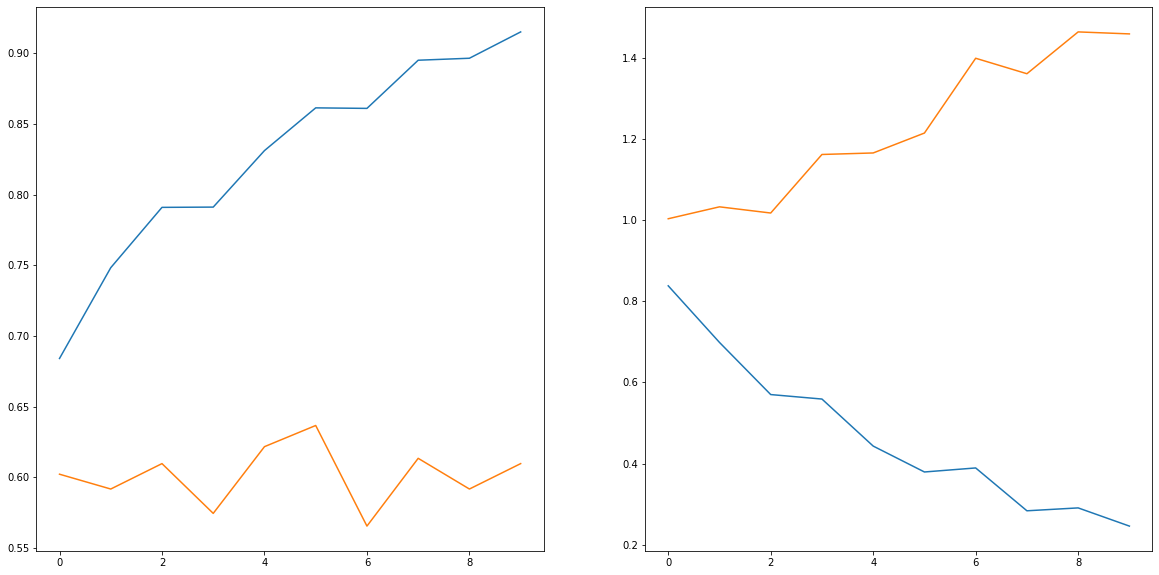

In [43]:
#knock87.py
device = torch.device('cuda')
model = CNN(len(wordids)+1, 300, 50, 4, len(wordids), vocabweights)
x_train, y_train = create_dataset(r'C:\Git\train.txt')
x_test, y_test = create_dataset(r'C:\Git\test.txt')
dataset = create_data(x_train, y_train)
train_loader = DataLoader(dataset, batch_size = 1, shuffle = True)
optim = torch.optim.SGD(model.parameters(), lr=0.003)
loss_func = nn.CrossEntropyLoss()
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
for epoch in tqdm(range(10)):
    for inputs, target in train_loader:
        optim.zero_grad()
        model.to(device)
        inputs = inputs.to(device)
        target = target.to(device)
        outputs = model(inputs)
        loss = loss_func(outputs, target)
        loss.backward()
        optim.step()
    with torch.no_grad():
        x_train = x_train.to(device)
        x_test = x_test.to(device)
        pred = model(x_train)
        train_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_train))
        train_loss.append(loss_func(pred, y_train.to(device)).detach().cpu().numpy())
        pred = model(x_test)
        test_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_test))
        test_loss.append(loss_func(pred, y_test.to(device)).detach().cpu().numpy())

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.subplot(1,2,2)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

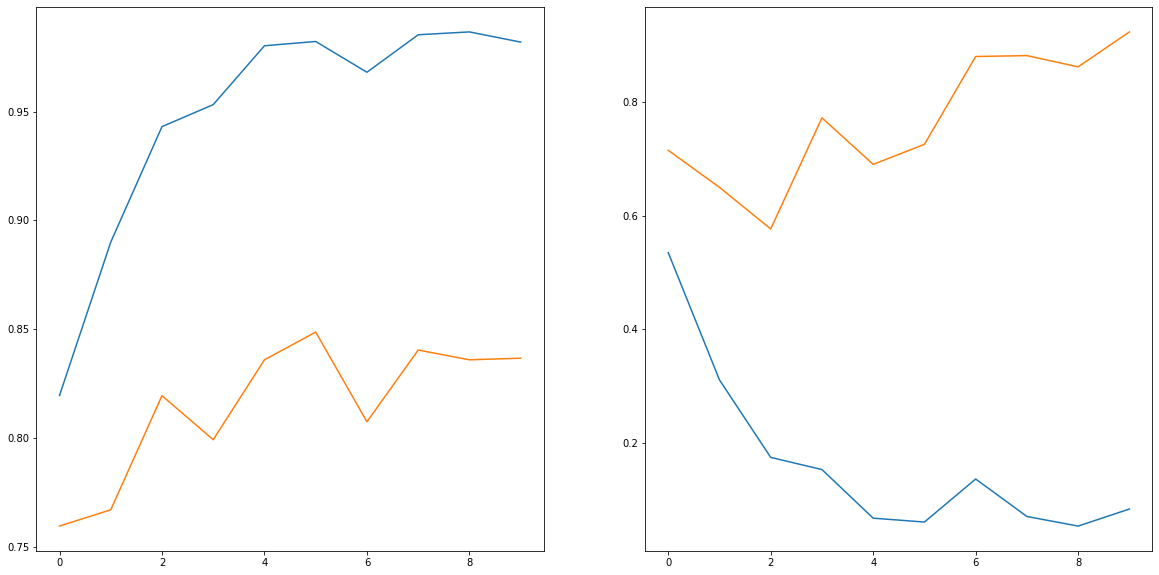

In [44]:
#knock88.py
device = torch.device('cuda')
model = CNN(len(wordids)+1, 300, 100, 4, len(wordids), vocabweights)
x_train, y_train = create_dataset(r'C:\Git\train.txt')
x_test, y_test = create_dataset(r'C:\Git\test.txt')
dataset = create_data(x_train, y_train)
train_loader = DataLoader(dataset, batch_size = 1, shuffle = True)
optim = torch.optim.AdamW(model.parameters(), lr=0.003)
loss_func = nn.CrossEntropyLoss()
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
for epoch in tqdm(range(10)):
    for inputs, target in train_loader:
        optim.zero_grad()
        model.to(device)
        inputs = inputs.to(device)
        target = target.to(device)
        outputs = model(inputs)
        loss = loss_func(outputs, target)
        loss.backward()
        optim.step()
    with torch.no_grad():
        x_train = x_train.to(device)
        x_test = x_test.to(device)
        pred = model(x_train)
        train_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_train))
        train_loss.append(loss_func(pred, y_train.to(device)).detach().cpu().numpy())
        pred = model(x_test)
        test_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_test))
        test_loss.append(loss_func(pred, y_test.to(device)).detach().cpu().numpy())

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.subplot(1,2,2)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.show()

In [7]:
#knock89.py
import transformers
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 20

def create_dataset(file_name):
    with open(file_name, encoding="utf-8") as f:
        x_vec=[]
        y_vec=[]
        for line in f:
            y, sent = line.strip().split('\t')
            x_vec.append(tokenizer.encode(sent, add_special_tokens=True))
            y_vec.append(int(y.translate(cat)))
        x_vec = ids2tensor(x_vec, max_len)
        y_vec = torch.tensor(y_vec, dtype = torch.int64)
        return x_vec, y_vec

class Bert(nn.Module):
    def __init__(self, output_size=4):
        super().__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.dropout = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768, output_size)
    
    def forward(self, ids):
        seg_ids = torch.zeros_like(ids)
        mask = (ids > 0)
        _, out = self.bert_model(input_ids = ids, token_type_ids = seg_ids, attention_mask=mask)
        out = self.fc(self.dropout(out))
        return out

device = torch.device('cuda')
model = Bert()
x_train, y_train = create_dataset(r'/content/drive/MyDrive/Dataset/train.txt')
x_test, y_test = create_dataset(r'/content/drive/MyDrive/Dataset/test.txt')
dataset = create_data(x_train, y_train)
train_loader = DataLoader(dataset, batch_size = 64, shuffle = True)
optim = torch.optim.AdamW(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
for epoch in tqdm(range(5)):
    for inputs, target in train_loader:
        optim.zero_grad()
        model.to(device)
        inputs = inputs.to(device)
        target = target.to(device)
        outputs = model(inputs)
        loss = loss_func(outputs, target)
        loss.backward()
        optim.step()
    with torch.no_grad():
        x_train = x_train.to(device)
        x_test = x_test.to(device)
        pred = model(x_train)
        train_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_train))
        train_loss.append(loss_func(pred, y_train.to(device)).detach().cpu().numpy())
        pred = model(x_test)
        test_accuracy.append(calc_accuracy(torch.argmax(pred, dim=1), y_test))
        test_loss.append(loss_func(pred, y_test.to(device)).detach().cpu().numpy())

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.subplot(1,2,2)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.show()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 